In [1]:
from baseline_cnn import *
from baseline_cnn import BasicCNN
from cnn_model1 import Model1CNN
from cnn_model2 import Model2CNN

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
from xray_dataloader import ChestXrayDataset, create_split_loaders

import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels) / float(labels.size)

In [3]:
def precision(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1))
    return TP / float(FP + TP + 1)

In [4]:
def recall(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0))
    return TP / float(FN + TP + 1)

In [5]:
def BCR(predictions, labels):
    return (precision(predictions, labels) + recall(predictions, labels)) / 2.0

In [6]:
def accuracy_per_class(predictions, labels):
    return np.sum(predictions == labels, axis=0) / float(labels.shape[0])

In [7]:
def precision_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1), axis=0)
    return TP / np.asfarray(FP + TP + 1)

In [8]:
def recall_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0), axis=0)
    return TP / np.asfarray(FN + TP + 1)

In [9]:
def BCR_per_class(predictions, labels):
    return (precision_per_class(predictions, labels) + recall_per_class(predictions, labels)) / 2.0

In [10]:
def confusion_matrix(mtx, predictions, actuals): 
    for p,a in zip(predictions, actuals):
        
        for i in range(p.shape[0]):
            # If TP, add 1 to diagonal
            # Then discard the other outputs
            if p[i] == 1 and a[i] == 1:
                mtx[i][i] += 1
                
            elif p[i] == 1:
                mtx[i] += a
    
    return mtx

In [11]:
def print_scores(batch_start, batch_count, accuracies, precisions, recalls, BCRs, aggregate=True):
    if aggregate:
        acc = np.mean(accuracies[batch_start:])
        pre = np.mean(precisions[batch_start:])
        rec = np.mean(recalls[batch_start:])
        bcr = np.mean(BCRs[batch_start:])
    else:
        acc = np.mean(accuracies[batch_start:], axis=0)
        pre = np.mean(precisions[batch_start:], axis=0)
        rec = np.mean(recalls[batch_start:], axis=0)
        bcr = np.mean(BCRs[batch_start:], axis=0)
            
    # Print the loss averaged over the last N mini-batches    
    print('Minibatch ' + str(batch_count) + ' accuracy: ' + str(acc))
    print('Minibatch ' + str(batch_count) + ' precision: ' + str(pre))
    print('Minibatch ' + str(batch_count) + ' recall: ' + str(rec))
    print('Minibatch ' + str(batch_count) + ' bcr: ' + str(bcr))

In [12]:
def train_model(run, model, model_name, num_epochs, train_loader, computing_device, optimizer, criterion):
    # Track the loss across training
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    
    start = time.time()
    
    # When to record results
    N_training_loss = len(train_loader) // 4
    N_minibatch_print = 50
    
    min_val_loss = 100    
    
    for epoch in range(num_epochs):
        
        # Training
        minibatch_loss_for_print = 0.0
        minibatch_loss_for_results = 0.0
        minibatch_acc_for_results = 0.0
        
        for minibatch_count, (images, labels) in enumerate(train_loader, 0):

            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                outputs = torch.sigmoid(outputs)
                
            predicted = torch.round(outputs.data)
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            acc = accuracy(predicted, labels)

            # Automagically compute the gradients and backpropagate the loss through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Add this iteration's loss to the total minibatch loss
            minibatch_loss_for_print += loss
            minibatch_loss_for_results += loss
            minibatch_acc_for_results += acc
            
            # Save the training loss every quarter of the training data
            if (minibatch_count + 1) % N_training_loss == 0:
                train_loss.append(minibatch_loss_for_results / N_training_loss)
                minibatch_loss_for_results = 0.0
                train_accuracy.append(minibatch_acc_for_results / N_training_loss)
                minibatch_acc_for_results = 0.0

            # Print the training loss every N_minibatches
            if (minibatch_count + 1) % N_minibatch_print == 0:   
                print('Run %d, Epoch %d, average minibatch %d loss: %.3f' %
                    (run, epoch + 1, minibatch_count + 1, minibatch_loss_for_print / N_minibatch_print))
                print(100 * minibatch_count/len(train_loader),"% done, " ,time.time() - start, " Seconds elapsed")
                
                minibatch_loss_for_print = 0.0
                
            #if len(train_accuracy) >= 2:
                #break

                
        # Validation
        val_loss = 0.0
        val_acc = 0.0
        early_stop_count = 0 
        
        # When to record results
        N_valid_loss = len(val_loader) // 4
        
        with torch.no_grad():
            for batch_count, (images, labels) in enumerate(val_loader, 0):
                images, labels = images.to(computing_device), labels.to(computing_device)

                optimizer.zero_grad()

                outputs = model(images)
                val_loss += criterion(outputs, labels)
                
                # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
                if isinstance(criterion, nn.BCEWithLogitsLoss):
                    outputs = torch.sigmoid(outputs)
                
                predicted = torch.round(outputs.data)
                predicted = predicted.cpu().numpy()
                labels = labels.cpu().numpy()
                val_acc += accuracy(predicted, labels)
                
                # Save the validation loss every quarter of the validation data
                if (batch_count + 1) % N_valid_loss == 0:
                    valid_loss.append(val_loss / N_valid_loss)
                    val_loss = 0.0
                    valid_accuracy.append(val_acc / N_valid_loss)
                    val_acc = 0.0
                    
                #if len(valid_accuracy) >= 2:
                    #break
                

            # Early stopping
            '''  
            if val_loss >= min_val_loss:
                early_stop_count += 1
                if early_stop_count == 2:
                    break

            else:
                early_stop_count = 0
                min_val_loss = val_loss
            '''

        print('Saving model')
        torch.save(model, model_name + str(epoch) + '_kf.pt')
        print("Finished", epoch + 1, "epochs of training")
        
    print("Training complete after", epoch + 1, "epochs")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy, time.time() - start

In [13]:
def test_model(model, test_loader, computing_device, optimizer, criterion):
    agg_accuracies = []
    agg_precisions = []
    agg_recalls = []
    agg_BCRs = []

    class_accuracies = []
    class_precisions = []
    class_recalls = []
    class_BCRs = []
    
    total_acc_per_class = [0] * 14
    total_pre_per_class = [0] * 14
    total_rec_per_class = [0] * 14
    total_BCR_per_class = [0] * 14
    
    conf_mtx = np.zeros((14, 14), dtype = np.float32)
    
    batch_start = 0
    N = 50

    with torch.no_grad():
        # Get the next minibatch of images, labels 
        for minibatch_count, (images, labels) in enumerate(test_loader, 0):
            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            #optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                outputs = torch.sigmoid(outputs)
            
            predicted = torch.round(outputs.data)

            # Convert from Cuda tensor -> numpy array
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()

            conf_mtx = confusion_matrix(conf_mtx, predicted, labels)

            # Compute aggregated scores
            acc = accuracy(predicted, labels)
            pre = precision(predicted, labels)
            rec = recall(predicted, labels)
            bcr = BCR(predicted, labels)

            agg_accuracies.append(acc)
            agg_precisions.append(pre)
            agg_recalls.append(rec)
            agg_BCRs.append(bcr)

            # Compute scores by class
            acc = accuracy_per_class(predicted, labels)
            pre = precision_per_class(predicted, labels)
            rec = recall_per_class(predicted, labels)
            bcr = BCR_per_class(predicted, labels)

            class_accuracies.append(acc)
            class_precisions.append(pre)
            class_recalls.append(rec)
            class_BCRs.append(bcr)
            
            total_acc_per_class += acc
            total_pre_per_class += pre
            total_rec_per_class += rec
            total_BCR_per_class += bcr

            if (minibatch_count + 1) % N == 0: 
                # Print the loss averaged over the last N mini-batches
                print('----- Aggregated Scores -----')
                print_scores(batch_start, minibatch_count, agg_accuracies, 
                             agg_precisions, agg_recalls, agg_BCRs, aggregate=True)
                '''
                print('----- Scores By Class -----')
                print_scores(batch_start, minibatch_count, class_accuracies, 
                             class_precisions, class_recalls, class_BCRs, aggregate=False)
                '''
                batch_start = minibatch_count + 1
                
                #break
                
                
    return total_acc_per_class / (minibatch_count + 1), total_pre_per_class / (minibatch_count + 1), total_rec_per_class / (minibatch_count + 1), total_BCR_per_class / (minibatch_count + 1), conf_mtx 

In [14]:
# Define the hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.4              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing

runs = 2                 # Used in k-fold validation

In [15]:
# BASELINE

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(512), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")



# trains the model
model = BasicCNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

class_accs = []
class_pres = []
class_recs = []
class_bcrs = []

conf_mtxs = []

for r in range(runs):
    # Setup the training, validation, and testing dataloaders
    train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)
    train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(r, model, 'Baseline', num_epochs, train_loader, computing_device, optimizer, criterion)
    class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    class_accs.append(class_acc)
    class_pres.append(class_pre)
    class_recs.append(class_rec)
    class_bcrs.append(class_bcr)
    conf_mtxs.append(conf_mtx)
    
train_losses = np.mean(train_losses, axis=0)
valid_losses = np.mean(valid_losses, axis=0)
train_accs = np.mean(train_accs, axis=0)
valid_accs = np.mean(valid_accs, axis=0)
class_accs = np.mean(class_accs, axis=0)
class_pres = np.mean(class_pres, axis=0)
class_recs = np.mean(class_recs, axis=0)
class_bcrs = np.mean(class_bcrs, axis=0)
conf_mtxs = np.mean(conf_mtxs, axis=0) 

# Normalize the confusion matrix
for j in range(conf_mtxs.shape[0]):
    if np.sum(conf_mtxs[j]) != 0:
        conf_mtxs[j] /= np.sum(conf_mtxs[j])
        
print('--------------------------------------------------------------------------')
print("Training loss")
print(train_losses)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_losses)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_accs)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_accs)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_accs)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pres)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_recs)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcrs)

print('--------------------------------------------------------------------------')
print("Confusion matrix")        
print(conf_mtxs)

CUDA is supported
Model on CUDA? True
Run 0, Epoch 1, average minibatch 50 loss: 0.425
1.4565992865636148 % done,  56.055487871170044  Seconds elapsed
Run 0, Epoch 1, average minibatch 100 loss: 0.228
2.942925089179548 % done,  111.53952836990356  Seconds elapsed
Run 0, Epoch 1, average minibatch 150 loss: 0.222
4.429250891795482 % done,  166.7456316947937  Seconds elapsed
Run 0, Epoch 1, average minibatch 200 loss: 0.222
5.915576694411415 % done,  221.82358598709106  Seconds elapsed
Run 0, Epoch 1, average minibatch 250 loss: 0.197
7.401902497027349 % done,  276.22957038879395  Seconds elapsed
Run 0, Epoch 1, average minibatch 300 loss: 0.211
8.888228299643282 % done,  330.1756830215454  Seconds elapsed
Run 0, Epoch 1, average minibatch 350 loss: 0.187
10.374554102259216 % done,  384.65739369392395  Seconds elapsed
Run 0, Epoch 1, average minibatch 400 loss: 0.203
11.860879904875148 % done,  438.5196781158447  Seconds elapsed
Run 0, Epoch 1, average minibatch 450 loss: 0.205
13.347205

Run 0, Epoch 2, average minibatch 300 loss: 0.183
8.888228299643282 % done,  7018.082492113113  Seconds elapsed
Run 0, Epoch 2, average minibatch 350 loss: 0.174
10.374554102259216 % done,  7072.015268087387  Seconds elapsed
Run 0, Epoch 2, average minibatch 400 loss: 0.171
11.860879904875148 % done,  7126.3805232048035  Seconds elapsed
Run 0, Epoch 2, average minibatch 450 loss: 0.167
13.347205707491081 % done,  7180.449620485306  Seconds elapsed
Run 0, Epoch 2, average minibatch 500 loss: 0.193
14.833531510107015 % done,  7235.13828420639  Seconds elapsed
Run 0, Epoch 2, average minibatch 550 loss: 0.189
16.31985731272295 % done,  7290.430365085602  Seconds elapsed
Run 0, Epoch 2, average minibatch 600 loss: 0.175
17.806183115338882 % done,  7344.160701274872  Seconds elapsed
Run 0, Epoch 2, average minibatch 650 loss: 0.165
19.292508917954816 % done,  7398.891313314438  Seconds elapsed
Run 0, Epoch 2, average minibatch 700 loss: 0.180
20.77883472057075 % done,  7453.222426176071  Se

----- Aggregated Scores -----
Minibatch 349 accuracy: 0.9490178571428571
Minibatch 349 precision: 0.02
Minibatch 349 recall: 0.0032500000000000003
Minibatch 349 bcr: 0.011625000000000002
----- Aggregated Scores -----
Minibatch 399 accuracy: 0.9511607142857141
Minibatch 399 precision: 0.04
Minibatch 399 recall: 0.006827985739750447
Minibatch 399 bcr: 0.023413992869875222
----- Aggregated Scores -----
Minibatch 449 accuracy: 0.9516071428571429
Minibatch 449 precision: 0.03666666666666667
Minibatch 449 recall: 0.006464932126696833
Minibatch 449 bcr: 0.02156579939668175
----- Aggregated Scores -----
Minibatch 499 accuracy: 0.9508928571428572
Minibatch 499 precision: 0.04
Minibatch 499 recall: 0.006083333333333333
Minibatch 499 bcr: 0.02304166666666667
----- Aggregated Scores -----
Minibatch 549 accuracy: 0.9436607142857142
Minibatch 549 precision: 0.05
Minibatch 549 recall: 0.007603396603396604
Minibatch 549 bcr: 0.028801698301698302
----- Aggregated Scores -----
Minibatch 599 accuracy: 0.

Run 1, Epoch 1, average minibatch 2850 loss: 0.176
84.69084423305588 % done,  3129.650805950165  Seconds elapsed
Run 1, Epoch 1, average minibatch 2900 loss: 0.171
86.17717003567182 % done,  3184.189624786377  Seconds elapsed
Run 1, Epoch 1, average minibatch 2950 loss: 0.182
87.66349583828776 % done,  3238.8143661022186  Seconds elapsed
Run 1, Epoch 1, average minibatch 3000 loss: 0.184
89.14982164090368 % done,  3293.529130220413  Seconds elapsed
Run 1, Epoch 1, average minibatch 3050 loss: 0.178
90.63614744351962 % done,  3347.793424844742  Seconds elapsed
Run 1, Epoch 1, average minibatch 3100 loss: 0.180
92.12247324613556 % done,  3402.7086267471313  Seconds elapsed
Run 1, Epoch 1, average minibatch 3150 loss: 0.171
93.6087990487515 % done,  3457.550857782364  Seconds elapsed
Run 1, Epoch 1, average minibatch 3200 loss: 0.179
95.09512485136742 % done,  3511.981034040451  Seconds elapsed
Run 1, Epoch 1, average minibatch 3250 loss: 0.170
96.58145065398335 % done,  3566.528332948684

Run 1, Epoch 2, average minibatch 3150 loss: 0.172
93.6087990487515 % done,  10289.232137680054  Seconds elapsed
Run 1, Epoch 2, average minibatch 3200 loss: 0.168
95.09512485136742 % done,  10344.962228298187  Seconds elapsed
Run 1, Epoch 2, average minibatch 3250 loss: 0.184
96.58145065398335 % done,  10400.483787059784  Seconds elapsed
Run 1, Epoch 2, average minibatch 3300 loss: 0.177
98.06777645659929 % done,  10455.630631685257  Seconds elapsed
Run 1, Epoch 2, average minibatch 3350 loss: 0.181
99.55410225921521 % done,  10511.152640104294  Seconds elapsed
Saving model
Finished 2 epochs of training
Training complete after 2 epochs
----- Aggregated Scores -----
Minibatch 49 accuracy: 0.9441964285714285
Minibatch 49 precision: 0.06166666666666666
Minibatch 49 recall: 0.009679217840982546
Minibatch 49 bcr: 0.035672942253824606
----- Aggregated Scores -----
Minibatch 99 accuracy: 0.9464285714285714
Minibatch 99 precision: 0.04666666666666666
Minibatch 99 recall: 0.010038461538461538


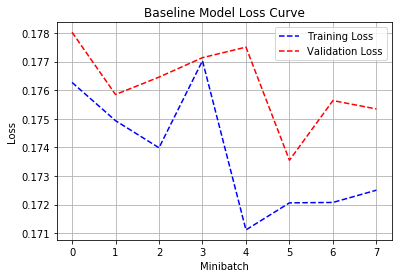

In [16]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Baseline Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m0_loss.png")

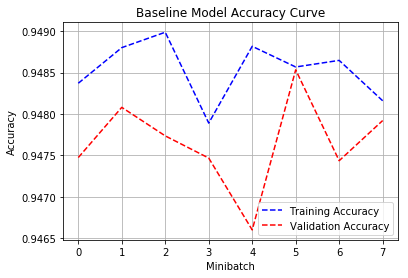

In [17]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m0_acc.png")

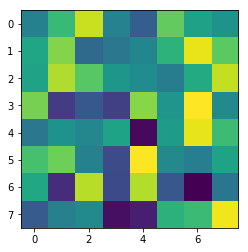

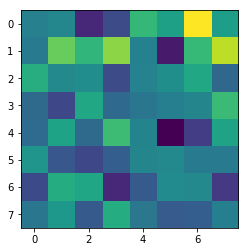

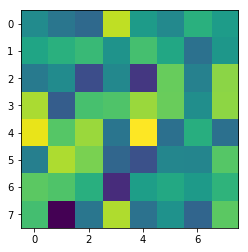

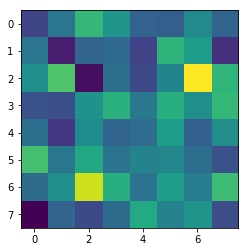

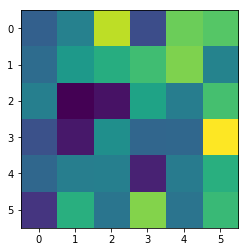

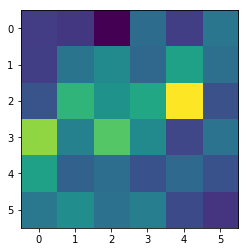

In [18]:
weights = model.conv1.weight.data.cpu().numpy()
plt.imsave('images/m0_early1.png', weights[0, 0])
plt.imsave('images/m0_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv2.weight.data.cpu().numpy()
plt.imsave('images/m0_mid1.png', weights[0, 0])
plt.imsave('images/m0_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m0_last1.png', weights[0, 0])
plt.imsave('images/m0_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# CUSTOM MODEL 1

# Define the model architecture and parameters
channel = [1, 8, 8, 8, 16, 16, 16, 32, 32, 32]
block_size = 3
kernel = [5]*9
pool_kernel = 2
pool_stride = 2
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Instantiate a BasicCNN to run on the GPU or CPU based on CUDA support
model = Model1CNN(256, channel, kernel, block_size, pool_kernel, pool_stride)
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

class_accs = []
class_pres = []
class_recs = []
class_bcrs = []

conf_mtxs = []

for r in range(runs):
    # Setup the training, validation, and testing dataloaders
    train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)
    train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(r, model, 'Custom1', num_epochs, train_loader, computing_device, optimizer, criterion)
    class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    class_accs.append(class_acc)
    class_pres.append(class_pre)
    class_recs.append(class_rec)
    class_bcrs.append(class_bcr)
    conf_mtxs.append(conf_mtx)
    
train_losses = np.mean(train_losses, axis=0)
valid_losses = np.mean(valid_losses, axis=0)
train_accs = np.mean(train_accs, axis=0)
valid_accs = np.mean(valid_accs, axis=0)
class_accs = np.mean(class_accs, axis=0)
class_pres = np.mean(class_pres, axis=0)
class_recs = np.mean(class_recs, axis=0)
class_bcrs = np.mean(class_bcrs, axis=0)
conf_mtxs = np.mean(conf_mtxs, axis=0) 

# Normalize the confusion matrix
for j in range(conf_mtxs.shape[0]):
    if np.sum(conf_mtxs[j]) != 0:
        conf_mtxs[j] /= np.sum(conf_mtxs[j])
        
print('--------------------------------------------------------------------------')
print("Training loss")
print(train_losses)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_losses)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_accs)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_accs)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_accs)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pres)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_recs)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcrs)

print('--------------------------------------------------------------------------')
print("Confusion matrix")        
print(conf_mtxs)

CUDA is supported
Model on CUDA? True
Run 0, Epoch 1, average minibatch 50 loss: 0.294
1.4565992865636148 % done,  53.08027458190918  Seconds elapsed
Run 0, Epoch 1, average minibatch 100 loss: 0.190
2.942925089179548 % done,  107.68443727493286  Seconds elapsed
Run 0, Epoch 1, average minibatch 150 loss: 0.211
4.429250891795482 % done,  162.08786988258362  Seconds elapsed
Run 0, Epoch 1, average minibatch 200 loss: 0.188
5.915576694411415 % done,  216.94074988365173  Seconds elapsed
Run 0, Epoch 1, average minibatch 250 loss: 0.186
7.401902497027349 % done,  271.01232385635376  Seconds elapsed
Run 0, Epoch 1, average minibatch 300 loss: 0.191
8.888228299643282 % done,  325.88274812698364  Seconds elapsed
Run 0, Epoch 1, average minibatch 350 loss: 0.178
10.374554102259216 % done,  380.32167291641235  Seconds elapsed
Run 0, Epoch 1, average minibatch 400 loss: 0.198
11.860879904875148 % done,  434.4750711917877  Seconds elapsed
Run 0, Epoch 1, average minibatch 450 loss: 0.174
13.34720

Run 0, Epoch 2, average minibatch 300 loss: 0.173
8.888228299643282 % done,  7079.264593839645  Seconds elapsed
Run 0, Epoch 2, average minibatch 350 loss: 0.179
10.374554102259216 % done,  7133.568746089935  Seconds elapsed
Run 0, Epoch 2, average minibatch 400 loss: 0.172
11.860879904875148 % done,  7188.045716762543  Seconds elapsed
Run 0, Epoch 2, average minibatch 450 loss: 0.176
13.347205707491081 % done,  7242.4699883461  Seconds elapsed
Run 0, Epoch 2, average minibatch 500 loss: 0.170
14.833531510107015 % done,  7297.960584402084  Seconds elapsed
Run 0, Epoch 2, average minibatch 550 loss: 0.159
16.31985731272295 % done,  7353.266519784927  Seconds elapsed
Run 0, Epoch 2, average minibatch 600 loss: 0.180
17.806183115338882 % done,  7409.620003461838  Seconds elapsed
Run 0, Epoch 2, average minibatch 650 loss: 0.165
19.292508917954816 % done,  7465.5042288303375  Seconds elapsed
Run 0, Epoch 2, average minibatch 700 loss: 0.177
20.77883472057075 % done,  7520.5186903476715  Se

----- Aggregated Scores -----
Minibatch 399 accuracy: 0.9482142857142858
Minibatch 399 precision: 0.05
Minibatch 399 recall: 0.008205128205128205
Minibatch 399 bcr: 0.0291025641025641
----- Aggregated Scores -----
Minibatch 449 accuracy: 0.9496428571428571
Minibatch 449 precision: 0.04666666666666666
Minibatch 449 recall: 0.007713950652031148
Minibatch 449 bcr: 0.027190308659348905
----- Aggregated Scores -----
Minibatch 499 accuracy: 0.9436607142857142
Minibatch 499 precision: 0.0
Minibatch 499 recall: 0.0
Minibatch 499 bcr: 0.0
----- Aggregated Scores -----
Minibatch 549 accuracy: 0.9476785714285714
Minibatch 549 precision: 0.01
Minibatch 549 recall: 0.0018181818181818182
Minibatch 549 bcr: 0.005909090909090909
----- Aggregated Scores -----
Minibatch 599 accuracy: 0.9477678571428573
Minibatch 599 precision: 0.01
Minibatch 599 recall: 0.0010526315789473684
Minibatch 599 bcr: 0.005526315789473684
----- Aggregated Scores -----
Minibatch 649 accuracy: 0.9434821428571428
Minibatch 649 pre

Run 1, Epoch 1, average minibatch 2950 loss: 0.167
87.66349583828776 % done,  3268.6377699375153  Seconds elapsed
Run 1, Epoch 1, average minibatch 3000 loss: 0.165
89.14982164090368 % done,  3325.6021666526794  Seconds elapsed
Run 1, Epoch 1, average minibatch 3050 loss: 0.173
90.63614744351962 % done,  3381.6575677394867  Seconds elapsed
Run 1, Epoch 1, average minibatch 3100 loss: 0.162
92.12247324613556 % done,  3438.780215740204  Seconds elapsed
Run 1, Epoch 1, average minibatch 3150 loss: 0.165
93.6087990487515 % done,  3494.2065422534943  Seconds elapsed
Run 1, Epoch 1, average minibatch 3200 loss: 0.169
95.09512485136742 % done,  3550.281387090683  Seconds elapsed
Run 1, Epoch 1, average minibatch 3250 loss: 0.158
96.58145065398335 % done,  3606.4072003364563  Seconds elapsed
Run 1, Epoch 1, average minibatch 3300 loss: 0.176
98.06777645659929 % done,  3663.079015493393  Seconds elapsed
Run 1, Epoch 1, average minibatch 3350 loss: 0.167
99.55410225921521 % done,  3720.752786636

Run 1, Epoch 2, average minibatch 3250 loss: 0.170
96.58145065398335 % done,  10604.437841653824  Seconds elapsed
Run 1, Epoch 2, average minibatch 3300 loss: 0.171
98.06777645659929 % done,  10663.71961760521  Seconds elapsed
Run 1, Epoch 2, average minibatch 3350 loss: 0.171
99.55410225921521 % done,  10722.821353197098  Seconds elapsed
Saving model
Finished 2 epochs of training
Training complete after 2 epochs
----- Aggregated Scores -----
Minibatch 49 accuracy: 0.9508035714285715
Minibatch 49 precision: 0.01
Minibatch 49 recall: 0.001176470588235294
Minibatch 49 bcr: 0.005588235294117647
----- Aggregated Scores -----
Minibatch 99 accuracy: 0.9466071428571428
Minibatch 99 precision: 0.04666666666666666
Minibatch 99 recall: 0.007672882672882673
Minibatch 99 bcr: 0.02716977466977467
----- Aggregated Scores -----
Minibatch 149 accuracy: 0.9474107142857142
Minibatch 149 precision: 0.04333333333333333
Minibatch 149 recall: 0.011571428571428571
Minibatch 149 bcr: 0.027452380952380954
----

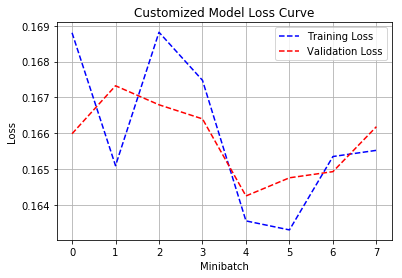

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Customized Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m1_loss.png")

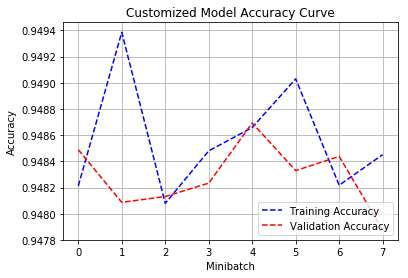

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Customized Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m1_acc.png")

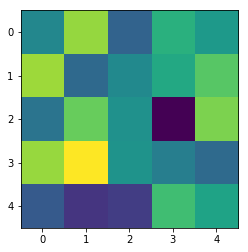

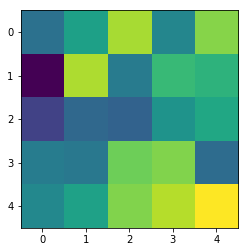

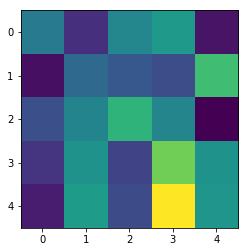

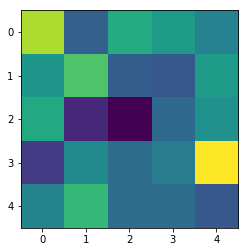

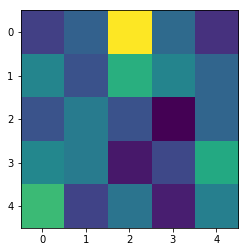

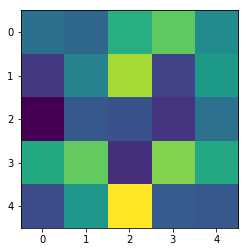

In [ ]:
weights = model.conv[2].weight.data.cpu().numpy()
plt.imsave('images/m1_early1.png', weights[0, 0])
plt.imsave('images/m1_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv[5].weight.data.cpu().numpy()
plt.imsave('images/m1_mid1.png', weights[0, 0])
plt.imsave('images/m1_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv[8].weight.data.cpu().numpy()
plt.imsave('images/m1_last1.png', weights[0, 0])
plt.imsave('images/m1_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# CUSTOM MODEL 2

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# trains the model
model = Model2CNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

class_accs = []
class_pres = []
class_recs = []
class_bcrs = []

conf_mtxs = []

for r in range(runs):
    # Setup the training, validation, and testing dataloaders
    train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)
    train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(r, model, 'Custom2', num_epochs, train_loader, computing_device, optimizer, criterion)
    class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    class_accs.append(class_acc)
    class_pres.append(class_pre)
    class_recs.append(class_rec)
    class_bcrs.append(class_bcr)
    conf_mtxs.append(conf_mtx)
    
train_losses = np.mean(train_losses, axis=0)
valid_losses = np.mean(valid_losses, axis=0)
train_accs = np.mean(train_accs, axis=0)
valid_accs = np.mean(valid_accs, axis=0)
class_accs = np.mean(class_accs, axis=0)
class_pres = np.mean(class_pres, axis=0)
class_recs = np.mean(class_recs, axis=0)
class_bcrs = np.mean(class_bcrs, axis=0)
conf_mtxs = np.mean(conf_mtxs, axis=0) 

# Normalize the confusion matrix
for j in range(conf_mtxs.shape[0]):
    if np.sum(conf_mtxs[j]) != 0:
        conf_mtxs[j] /= np.sum(conf_mtxs[j])
        
print('--------------------------------------------------------------------------')
print("Training loss")
print(train_losses)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_losses)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_accs)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_accs)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_accs)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pres)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_recs)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcrs)

print('--------------------------------------------------------------------------')
print("Confusion matrix")        
print(conf_mtxs)

CUDA is supported
Model on CUDA? True
Run 0, Epoch 1, average minibatch 50 loss: 0.240
1.4565992865636148 % done,  60.056631326675415  Seconds elapsed
Run 0, Epoch 1, average minibatch 100 loss: 0.192
2.942925089179548 % done,  119.43772983551025  Seconds elapsed
Run 0, Epoch 1, average minibatch 150 loss: 0.185
4.429250891795482 % done,  177.921781539917  Seconds elapsed
Run 0, Epoch 1, average minibatch 200 loss: 0.187
5.915576694411415 % done,  236.35222101211548  Seconds elapsed
Run 0, Epoch 1, average minibatch 250 loss: 0.175
7.401902497027349 % done,  294.1817829608917  Seconds elapsed
Run 0, Epoch 1, average minibatch 300 loss: 0.192
8.888228299643282 % done,  352.4019024372101  Seconds elapsed
Run 0, Epoch 1, average minibatch 350 loss: 0.185
10.374554102259216 % done,  411.24310517311096  Seconds elapsed
Run 0, Epoch 1, average minibatch 400 loss: 0.190
11.860879904875148 % done,  470.35417771339417  Seconds elapsed
Run 0, Epoch 1, average minibatch 450 loss: 0.174
13.3472057

Run 0, Epoch 2, average minibatch 300 loss: 0.172
8.888228299643282 % done,  7464.980274677277  Seconds elapsed
Run 0, Epoch 2, average minibatch 350 loss: 0.170
10.374554102259216 % done,  7520.313509941101  Seconds elapsed
Run 0, Epoch 2, average minibatch 400 loss: 0.190
11.860879904875148 % done,  7576.554470062256  Seconds elapsed
Run 0, Epoch 2, average minibatch 450 loss: 0.172
13.347205707491081 % done,  7633.958178520203  Seconds elapsed
Run 0, Epoch 2, average minibatch 500 loss: 0.165
14.833531510107015 % done,  7691.172614097595  Seconds elapsed
Run 0, Epoch 2, average minibatch 550 loss: 0.172
16.31985731272295 % done,  7748.715947389603  Seconds elapsed
Run 0, Epoch 2, average minibatch 600 loss: 0.164
17.806183115338882 % done,  7805.831396341324  Seconds elapsed
Run 0, Epoch 2, average minibatch 650 loss: 0.169
19.292508917954816 % done,  7862.624264240265  Seconds elapsed
Run 0, Epoch 2, average minibatch 700 loss: 0.172
20.77883472057075 % done,  7920.339832305908  Se

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m2_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m2_acc.png")

In [ ]:
weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m2_early1.png', weights[0, 0])
plt.imsave('images/m2_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv6.weight.data.cpu().numpy()
plt.imsave('images/m2_mid1.png', weights[0, 0])
plt.imsave('images/m2_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv12.weight.data.cpu().numpy()
plt.imsave('images/m2_last1.png', weights[0, 0])
plt.imsave('images/m2_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# RERUN CUSTOM MODEL 2 WITH CLASS BALANCING

# Define the model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")


# Train the model
model = Model2CNN(skip_sigmoid=True)
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

class_accs = []
class_pres = []
class_recs = []
class_bcrs = []

conf_mtxs = []

for r in range(runs):
    # Setup the training, validation, and testing dataloaders
    train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)
    
    # Creates the weights to address the class imbalance
    total_data_points = 0
    if use_cuda:
        total_class_counts = torch.cuda.FloatTensor(14).fill_(0)
    else:
        total_class_counts = torch.FloatTensor(14).fill_(0)    
        
    N = 50
    NN = 100
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        total_data_points += labels.shape[0]
        total_class_counts += torch.sum(labels, dim = 0).cuda()
        if (minibatch_count + 1) % N == 0:
            print("Finished counting minibatch " + str(minibatch_count + 1))
            print("Total data points = " + str(total_data_points))
            print("Total class counts = " + str(total_class_counts))
        if (minibatch_count + 1) % NN == 0:
            break

    inverse_class_frequency = (total_data_points - total_class_counts) / (total_class_counts + 1)

    print('--------------------------------------------------------------------------')
    print("Inverse Class Frequency")
    print(inverse_class_frequency)
    
    # Define the loss criterion and instantiate the gradient descent optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=inverse_class_frequency)
    
    train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(r, model, 'Custom2ClassBalance', num_epochs, train_loader, computing_device, optimizer, criterion)
    class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    class_accs.append(class_acc)
    class_pres.append(class_pre)
    class_recs.append(class_rec)
    class_bcrs.append(class_bcr)
    conf_mtxs.append(conf_mtx)
    
train_losses = np.mean(train_losses, axis=0)
valid_losses = np.mean(valid_losses, axis=0)
train_accs = np.mean(train_accs, axis=0)
valid_accs = np.mean(valid_accs, axis=0)
class_accs = np.mean(class_accs, axis=0)
class_pres = np.mean(class_pres, axis=0)
class_recs = np.mean(class_recs, axis=0)
class_bcrs = np.mean(class_bcrs, axis=0)
conf_mtxs = np.mean(conf_mtxs, axis=0) 

# Normalize the confusion matrix
for j in range(conf_mtxs.shape[0]):
    if np.sum(conf_mtxs[j]) != 0:
        conf_mtxs[j] /= np.sum(conf_mtxs[j])
        
print('--------------------------------------------------------------------------')
print("Training loss")
print(train_losses)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_losses)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_accs)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_accs)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_accs)

print('--------------------------------------------------------------------------')
print("Per class precision")
print(class_pres)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_recs)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcrs)

print('--------------------------------------------------------------------------')
print("Confusion matrix")        
print(conf_mtxs)

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 With Class Balancing Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m3_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'Validation Accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 With Class Balancing Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m3_acc.png")

In [ ]:
weights = model.conv3.weight.data.cpu().numpy()
plt.imsave('images/m3_early1.png', weights[0, 0])
plt.imsave('images/m3_early2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv6.weight.data.cpu().numpy()
plt.imsave('images/m3_mid1.png', weights[0, 0])
plt.imsave('images/m3_mid2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

weights = model.conv12.weight.data.cpu().numpy()
plt.imsave('images/m3_last1.png', weights[0, 0])
plt.imsave('images/m3_last2.png', weights[1, 0])
plt.figure().add_subplot(111).imshow(weights[0, 0])
plt.figure().add_subplot(111).imshow(weights[1, 0])

In [ ]:
# Loads the model
# model2 = torch.load('file_name')